## Imports

In [5]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
from dask_ml.impute import SimpleImputer
#from dask_ml.xgboost import XGBClassifier
#from dask_ml.preprocessing import LabelEncoder
#from dask_ml.model_selection import KFold
#from dask_ml.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegression
from dask.distributed import Client, LocalCluster
from dask import compute
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import LabelEncoder

In [4]:
SEED = 0
JOBS = 10

In [3]:
cluster = LocalCluster(n_workers=JOBS)
client = Client(cluster)

## Data Exploration

In [4]:
data = df.read_csv('./data/train_transaction.csv', header=0)

In [5]:
data

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
npartitions=11,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,float64,object,int64,float64,float64,object,float64,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [5]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 394 entries, TransactionID to V339
dtypes: object(14), float64(376), int64(4)

In [5]:
data['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

### Missing Values

In [11]:
data.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [6]:
X = data[['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6']]
y = data['isFraud']
X

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
npartitions=11,,,,,,,,
,float64,object,int64,float64,float64,object,float64,object
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [7]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [8]:
X[['card1', 'card2', 'card3', 'card5']] = mean_imp.fit_transform(X[['card1', 'card2', 'card3', 'card5']])
X[['card4', 'card6']] = mode_imp.fit_transform(X[['card4', 'card6']])

In [27]:
X.isnull().sum().compute()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
dtype: int64

In [39]:
def name(i):
    return f'{i}'

In [40]:
X.to_csv('./data/base_features/*.csv', header=True, index=False, name_function=name)
y.to_csv('./data/target/*.csv', header=True, index=False, name_function=name)

In order to preserve order between partitions paths created with ``name_function`` should sort to partition order
In order to preserve order between partitions paths created with ``name_function`` should sort to partition order


['/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/0.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/1.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/2.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/3.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/4.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/5.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/6.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/7.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/8.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/9.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/10.csv']

In [24]:
X = df.read_csv('./data/base_features/*.csv', header=0)
y = df.read_csv('./data/target/*.csv', header=0)

In [27]:
y_pos = y[y['isFraud']==1]
y_neg = y[y['isFraud']==0]
          
X_pos = X.loc[y_pos.index, :]
X_neg = X.loc[y_neg.index, :].sample(frac=0.1, random_state=SEED)

X_pos, X_neg, y_pos, y_neg = compute(X_pos, X_neg, y_pos, y_neg)

<AxesSubplot:xlabel='card6', ylabel='count'>

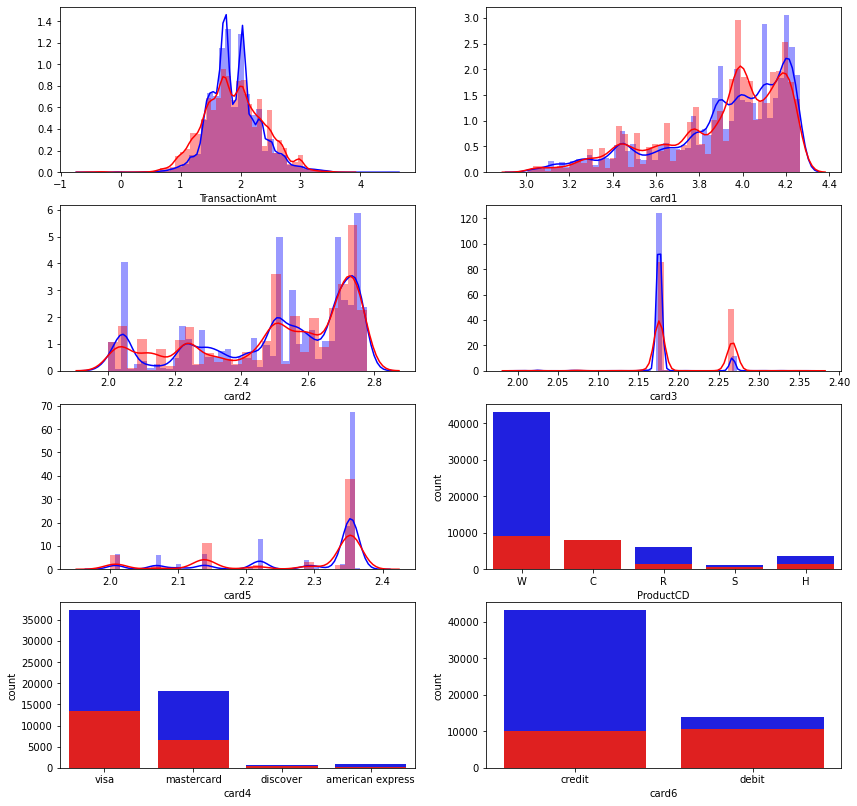

In [28]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,14))
sns.distplot(a=numpy.log10(X_neg['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(X_pos['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(X_neg['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(X_pos['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(X_neg['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(X_pos['card2']), ax=ax[1,0], color='red')
sns.distplot(a=numpy.log10(X_neg['card3']), ax=ax[1,1], color='blue')
sns.distplot(a=numpy.log10(X_pos['card3']), ax=ax[1,1], color='red')
sns.distplot(a=numpy.log10(X_neg['card5']), ax=ax[2,0], color='blue')
sns.distplot(a=numpy.log10(X_pos['card5']), ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=X_neg, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=X_pos, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=X_neg, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=X_pos, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=X_neg, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=X_pos, ax=ax[3,1], color='red')

In [29]:
X = pandas.concat([X_pos, X_neg])

In [30]:
X[['ProductCD', 'card4', 'card6']] = X[['ProductCD', 'card4', 'card6']].apply(LabelEncoder().fit_transform)

In [31]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
203,445.000,4,18268,583.0,150.0,3,226.0,1
240,37.098,0,13413,103.0,185.0,3,137.0,1
243,37.098,0,13413,103.0,185.0,3,137.0,1
245,37.098,0,13413,103.0,185.0,3,137.0,1
288,155.521,0,16578,545.0,185.0,3,226.0,1


In [32]:
X_ = MinMaxScaler().fit_transform(X)

In [ ]:
X_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(X_)

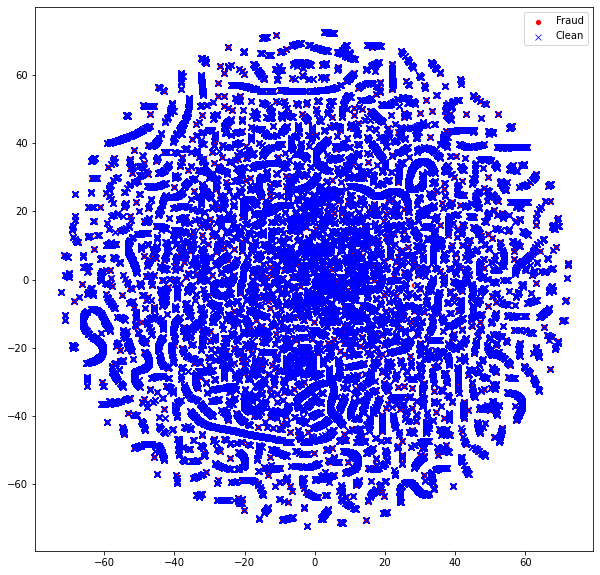

In [107]:

plt.figure(figsize=(10,10))
sns.scatterplot(x=X_.loc[0:X_pos.shape[0], 0], y=X_.loc[0:X_pos.shape[0], 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=X_.loc[X_pos.shape[0]:, 0], y=X_.loc[X_pos.shape[0]:, 1], color='blue', marker='x', label='Clean')
plt.legend()

In [14]:
X[['card4', 'card6', 'ProductCD']] = X[['card4', 'card6', 'ProductCD']].astype('category')

In [15]:
X = X.categorize(columns=['card4', 'card6', 'ProductCD'])

In [16]:
X_ = pandas.get_dummies(X, columns=['card4', 'card6', 'ProductCD'], drop_first=True)

In [17]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,68.5,13926,362.555488,150.0,142.0,1,0,0,1,0,0,0,0,0,1
1,29.0,2755,404.000000,150.0,102.0,0,1,0,1,0,0,0,0,0,1
2,59.0,4663,490.000000,150.0,166.0,0,0,1,0,1,0,0,0,0,1
3,50.0,18132,567.000000,150.0,117.0,0,1,0,0,1,0,0,0,0,1
4,50.0,4497,514.000000,150.0,102.0,0,1,0,1,0,0,1,0,0,0


In [19]:
X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']] = numpy.log10(X_[['TransactionAmt','card1', 'card2', 'card3', 'card5']]) 

In [20]:
X_.head()

,TransactionAmt,card1,card2,card3,card5,card4_discover,card4_mastercard,card4_visa,card6_credit,card6_debit,card6_debit or credit,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
0,1.835691,4.143826,2.559374,2.176091,2.152288,1,0,0,1,0,0,0,0,0,1
1,1.462398,3.440122,2.606381,2.176091,2.008600,0,1,0,1,0,0,0,0,0,1
2,1.770852,3.668665,2.690196,2.176091,2.220108,0,0,1,0,1,0,0,0,0,1
3,1.698970,4.258446,2.753583,2.176091,2.068186,0,1,0,0,1,0,0,0,0,1
4,1.698970,3.652923,2.710963,2.176091,2.008600,0,1,0,1,0,0,1,0,0,0


In [23]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
#cv = KFold(n_splits=10, shuffle=True, random_state=SEED)

In [25]:
for train_index, test_index in cv.split(X_, y_):
    
    train_index = train_index.tolist()
    test_index = test_index.tolist()
    
    X_train, X_test, y_train, y_test = X_[train_index, :], X_[test_index, :], y_[train_index], y_[test_index]
    y1, y2 = y_train[y_train==1], y_train[y_train==0]
    y3, y4 = y_test[y_test==1], y_test[y_test==0]

    lr = LogisticRegression(random_state=SEED)
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)
    y_pred, y_test = compute(y_pred, y_test)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    print(recall)

0.0
0.0
0.0


KeyboardInterrupt: 